In [1]:
import numpy as np
import pandas as pd
import catboost
import imblearn
import seaborn as sns
from catboost import CatBoostClassifier, Pool
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,confusion_matrix,accuracy_score
from sklearn.feature_extraction.text import TfidfVectorizer
from imblearn.combine import SMOTEENN
import matplotlib.pyplot as plt
import optuna
from imblearn.over_sampling import SMOTE
from optuna.samplers import TPESampler
from sklearn.metrics import matthews_corrcoef
from sklearn.preprocessing import LabelEncoder

In [2]:
df= pd.read_csv('Top_df.csv')
df.shape

(335113, 21)

<Axes: xlabel='target'>

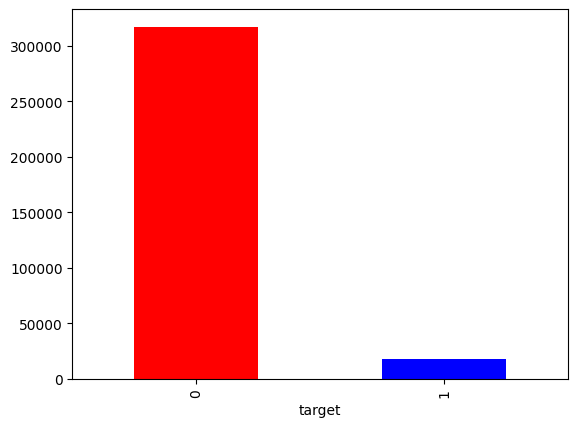

In [3]:
df['target'].value_counts().plot(kind='bar', color = ['red', 'blue'])

In [4]:
df['target'].value_counts(normalize=True)

target
0    0.946466
1    0.053534
Name: proportion, dtype: float64

In [5]:
# Selecting columns with data type 'object' (string) for df1
df1 = df.select_dtypes(include='object')

# Selecting columns with data type 'int64' for df2
df2 = df.select_dtypes(include=['int64','float64'])

In [6]:
# Convert all columns to categorical data type
df2 = df2.astype('category')

In [7]:
df2['target'] = df2['target'].astype('int')

### TF-IDF vectorize

In [8]:
# List of columns to transform with TF-IDF
columns_to_transform = ['os_105','os_108', 'os_109', 'os_111']

# Concatenate the text from these columns into a single series of strings
# Each row will contain the concatenated text from all specified columns
text_data = df1[columns_to_transform].apply(lambda x: ' '.join(x.dropna()), axis=1)

# Initialize the TF-IDF Vectorizer
vectorizer = TfidfVectorizer(ngram_range=(1, 2),max_features=500,max_df=0.99, min_df=0.01)

# Fit and transform the concatenated text data to get the TF-IDF features
tfidf_matrix = vectorizer.fit_transform(text_data)

In [9]:
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

In [10]:
df2.shape,tfidf_df.shape

((335113, 17), (335113, 193))

### Concatenation

In [11]:
# Concatenate the dataframes
Top_df = pd.concat([df2.reset_index(drop=True),tfidf_df.reset_index(drop=True)], axis=1)

In [12]:
Top_df.shape

(335113, 210)

### Oversampling

In [13]:
# Splitting the dataset into X and y
X = Top_df.drop('target', axis=1)  # Features: all columns except 'target'
y = Top_df['target']

In [14]:
# Split the dataset into 70% training and 30% temporary test set
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# Split the temporary test set into 50% test and 50% validation, which makes it 15% of the original dataset each
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [15]:
# # Apply SMOTE-ENN
# smote_enn = SMOTEENN(sampling_strategy='auto',random_state=42)
# X_res, y_res = smote_enn.fit_resample(X, y)

In [16]:
X_train.shape,X_test.shape,X_val.shape

((234579, 209), (50267, 209), (50267, 209))

In [17]:
sm = SMOTE(random_state=42)
X_train, y_train = sm.fit_resample(X_train, y_train)

In [18]:
X_train.shape,y_train.shape

((444126, 209), (444126,))

In [19]:
y_train.value_counts()

target
0    222063
1    222063
Name: count, dtype: int64

In [20]:
y_train.value_counts(normalize=True)

target
0    0.5
1    0.5
Name: proportion, dtype: float64

In [21]:
# # Split the dataset into 70% training and 30% temporary test set
# X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42)

# # Split the temporary test set into 50% test and 50% validation, which makes it 15% of the original dataset each
# X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

In [22]:
categorical_features = ['ContactMonth', 'ContactHour', 'os_112', 'os_110', 's_247_71',
       's_239_8', 's_247_75', 's_239_7', 's_248_74', 's_247_77', 's_239_9',
       's_241_68', 's_241_69', 's_247_78', 's_239_10', 's_247_73']

In [23]:
# for col in categorical_features:
#     X_train[col] = X_train[col].astype(str)
for feature in categorical_features:
    X_train[feature] = X_train[feature].astype(str)
    X_test[feature] = X_test[feature].astype(str)
    X_val[feature] = X_val[feature].astype(str)

In [24]:
# for column in categorical_features:
#     # Convert to string, including NaNs which become 'nan'
#     X[column] = X[column].astype(str)

#     # Optional: Replace 'nan' with a placeholder such as 'missing'
#     X[column] = X[column].replace('nan', 'missing')

In [25]:
pool = Pool(X_train, y_train, cat_features=categorical_features, feature_names=list(X.columns))

In [26]:
catboost_model = CatBoostClassifier(
    iterations = 1000,
    learning_rate = 0.01,
    reg_lambda=0.5,
    eval_metric='Logloss',
    max_depth = 9,
    colsample_bylevel = 0.72706679,
    random_strength = 1.64047,
    random_state = 42,
    bootstrap_type = 'Bayesian',
    bagging_temperature= 4.53847,
    auto_class_weights = 'Balanced'
    )

catboost_model.fit(pool,eval_set = [(X_test, y_test)], use_best_model=True, early_stopping_rounds=50)

0:	learn: 0.6817161	test: 0.6742817	best: 0.6742817 (0)	total: 2.02s	remaining: 33m 34s
1:	learn: 0.6704615	test: 0.6561863	best: 0.6561863 (1)	total: 3.68s	remaining: 30m 36s
2:	learn: 0.6601811	test: 0.6394427	best: 0.6394427 (2)	total: 5.32s	remaining: 29m 29s
3:	learn: 0.6508099	test: 0.6242273	best: 0.6242273 (3)	total: 6.95s	remaining: 28m 49s
4:	learn: 0.6416396	test: 0.6096921	best: 0.6096921 (4)	total: 8.66s	remaining: 28m 44s
5:	learn: 0.6336297	test: 0.5969640	best: 0.5969640 (5)	total: 10.7s	remaining: 29m 29s
6:	learn: 0.6257280	test: 0.5845590	best: 0.5845590 (6)	total: 12.3s	remaining: 29m 4s
7:	learn: 0.6187029	test: 0.5736508	best: 0.5736508 (7)	total: 13.9s	remaining: 28m 46s
8:	learn: 0.6113841	test: 0.5627265	best: 0.5627265 (8)	total: 15.4s	remaining: 28m 20s
9:	learn: 0.6047758	test: 0.5525211	best: 0.5525211 (9)	total: 16.3s	remaining: 26m 48s
10:	learn: 0.5982453	test: 0.5431241	best: 0.5431241 (10)	total: 17.8s	remaining: 26m 44s
11:	learn: 0.5925202	test: 0.53

In [27]:
y_pred_test = catboost_model.predict(X_test)
y_pred_train = catboost_model.predict(X_train)
y_pred_val = catboost_model.predict(X_val)

### Train

In [28]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_train, y_pred_train)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 95546 126517]
 [    15 222048]]


In [29]:
# Evaluating the model
accuracy = accuracy_score(y_train, y_pred_train)
print(f"Accuracy on trn set: {accuracy}")

Accuracy on trn set: 0.715098868339165


In [30]:
# Evaluating the model
f1 = f1_score(y_train, y_pred_train)
print(f"f1 on train set: {f1}")

f1 on train set: 0.7782583399342479


In [31]:
# Evaluating the model
f1 = f1_score(y_train, y_pred_train,average='weighted')
print(f"f1 on train set: {f1}")

f1 on train set: 0.6899439698563011


In [32]:
matthews_corrcoef(y_train, y_pred_train)

0.5234341970862729

### Test

In [33]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred_test)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[20391 27183]
 [    4  2689]]


In [34]:
# Evaluating the model
accuracy = accuracy_score(y_test, y_pred_test)
print(f"Accuracy on test set: {accuracy}")

Accuracy on test set: 0.45914814888495437


In [35]:
# Evaluating the model
f1 = f1_score(y_test, y_pred_test)
print(f"f1 on test set: {f1}")

f1 on test set: 0.1651466298172885


In [36]:
# Evaluating the model
f1 = f1_score(y_test, y_pred_test,average='weighted')
print(f"f1 on test set: {f1}")

f1 on test set: 0.5767115570083649


In [37]:
matthews_corrcoef(y_test, y_pred_test)

0.19587104454200865

### val

In [38]:
# Confusion Matrix
conf_matrix = confusion_matrix(y_val, y_pred_val)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[20444 27092]
 [    7  2724]]


In [39]:
# Evaluating the model
accuracy = accuracy_score(y_val, y_pred_val)
print(f"Accuracy on val set: {accuracy}")

Accuracy on val set: 0.46089880040583286


In [40]:
# Evaluating the model
f1 = f1_score(y_val, y_pred_val)
print(f"f1 on val set: {f1}")

f1 on val set: 0.16738869941930132


In [41]:
# Evaluating the model
f1 = f1_score(y_val, y_pred_val,average='weighted')
print(f"f1 on val set: {f1}")

f1 on val set: 0.5778288176917875


In [42]:
matthews_corrcoef(y_val, y_pred_val)

0.19725925132018285

### Threshold value

In [66]:
# # # Predict probabilities for the positive class
# y_prob_test = catboost_model.predict_proba(X_test)[:, 1]

In [ ]:
# # Calculate F1 scores for different threshold values
# threshold_values = np.arange(0, 1.0, 0.001)
# f1_scores = []
# for threshold in threshold_values:
#     y_pred_threshold = (y_prob_test > threshold).astype(int)
#     f1_scores.append(f1_score(y_test, y_pred_threshold))

# # Find the threshold value with the highest F1 score
# best_threshold = threshold_values[np.argmax(f1_scores)]
# best_f1_score = np.max(f1_scores)

# print("Best Threshold:", best_threshold)
# print("Best F1 Score:", best_f1_score)

### Hyperparameter Tunning

In [ ]:
def objective(trial):
    params = {
        "iterations":500,
        #"logging_level":'silent',
        #"verbose":0,
        "learning_rate": 0.01,
        "max_depth": trial.suggest_int("max_depth", 3,10),
        # "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 20,100),
        "random_state": 42,
        # "subsample": trial.suggest_uniform('subsample', 0.5, 1.0),
        "colsample_bylevel": trial.suggest_float('colsample_bylevel', 0.3, 1.0),
        "random_strength": trial.suggest_float("random_strength", 1, 10.0),
        "bagging_temperature": trial.suggest_float("bagging_temperature", 0.2, 5.0),
        "bootstrap_type": 'Bayesian',
        "eval_metric":'Logloss',
        "auto_class_weights":'Balanced'
    }

    model = catboost.CatBoostClassifier(**params, silent=True)
    # model.fit(X_train, y_train)
    model.fit(pool)
    # y_pred_test = model.predict_proba(X_test)
    y_pred_val = model.predict(X_val)
    f1 = f1_score(y_val, y_pred_val)
    return f1

sampler = TPESampler(seed=42)
study = optuna.create_study(direction='maximize',sampler=sampler)
study.optimize(objective, n_trials=100)

print('Best hyperparameters:', study.best_params)
print('Best F1:', study.best_value)

[I 2024-04-16 05:52:42,722] A new study created in memory with name: no-name-1801edb6-0b14-4ef2-bdd5-487691502972
[I 2024-04-16 05:55:02,175] Trial 0 finished with value: 0.7800476066257989 and parameters: {'max_depth': 5, 'colsample_bylevel': 0.9655000144869412, 'random_strength': 7.587945476302646, 'bagging_temperature': 3.073560724145776}. Best is trial 0 with value: 0.7800476066257989.
[I 2024-04-16 05:56:38,421] Trial 1 finished with value: 0.7800476066257989 and parameters: {'max_depth': 4, 'colsample_bylevel': 0.40919616423534183, 'random_strength': 1.5227525095137953, 'bagging_temperature': 4.3576454997196885}. Best is trial 0 with value: 0.7800476066257989.
[I 2024-04-16 05:59:40,544] Trial 2 finished with value: 0.781082693738097 and parameters: {'max_depth': 7, 'colsample_bylevel': 0.7956508044572318, 'random_strength': 1.185260448662222, 'bagging_temperature': 4.855567290377572}. Best is trial 2 with value: 0.781082693738097.
[I 2024-04-16 06:02:52,438] Trial 3 finished wit

In [ ]:
{'max_depth': 10, 'colsample_bylevel': 0.43515206169674575, 'random_strength': 1.5407483551397285, 'bagging_temperature': 2.7711981398969723}